In [1]:
import datajoint as dj
dj.config['database.host'] = 'tutorial-db.datajoint.io'
dj.config['database.user'] = 'dimitri'
dj.config['names.djcat_lab'] = 'catalog_lab_dimitri2'

In [2]:
import djcat_lab as lab

Connecting dimitri@tutorial-db.datajoint.io:3306


In [3]:
schema = dj.schema('catalog_ssc_dimitri', locals())

In [4]:
@schema
class Session(dj.Manual):
    definition = """
    -> lab.Subject
    session : int unsigned   # session for animal
    --- 
    -> lab.Study
    (experimenter) -> lab.User
    start_time   : date    # date on which the session 
    session_suffix='': char(2)         # suffix used by experimenter when identifying session by date
    session_notes='' : varchar(4000)   # free-text notes
    session_folder='': varchar(255)    # path to session data for data import
    """

In [5]:
@schema
class CorrectResponse(dj.Lookup):
    definition = """
    # CorrectResponse
    correct_response : varchar(12)  # the correct response for a trial
    """
    contents = zip(['lick-left', 'lick-right'])


@schema
class CueType(dj.Lookup):
    definition = """
    cue_type : varchar(8)  
    """
    contents = zip(['start', 'response'])


@schema
class WhiskerBehavior(dj.Imported):
    definition = """
    -> Session
    """

    class Angles(dj.Part):
        definition = """
        -> WhiskerBehavior
        ---
        angle         : longblob   # (degrees) deviation
        curve         : longblob   # (radians/mm)   
        frame_times   : longblob   # (s)
        """
    
    class WhiskerTouch(dj.Part):
        definition = """
        -> WhiskerBehavior
        ---
        retract_times   : longblob  # (s)    
        protract_times  : longblob  # (s)
        """

@schema
class Licking(dj.Imported):
    definition = """
    # Licking 
    -> Session
    ---
    left_lick_times   : longblob    
    right_lick_times  : longblob
    """
    
    
@schema
class Trial(dj.Imported):
    definition = """
    # Trial within a session
    -> Session
    trial   : smallint   # trial number within session
    ---
    -> CorrectResponse
    start_time : float   # (s) synchronized
    stop_time  : float   # (s) synchronized
    """
    
    class Cue(dj.Part):
        definition = """
        -> Trial
        -> CueType 
        ---
        cue_time  : double                      # synchronized
        """

In [6]:
@schema
class Imaging(dj.Imported):
    definition = """
    -> Session 
    ---
    laser_wavelength   :   decimal(5,1)   # (nm)
    """

@schema
class Volume(dj.Imported):
    definition = """
    # A two-photon imaging volume
    -> Session
    volume  : int 
    ---
    volume_position   :  blob   #
    """
    
@schema
class Subvolume(dj.Imported):
    definition = """
    # Two-photon imaging subvolume
    -> Volume
    subvolume  : int   # subvolume within a volume 
    ---
    fov_x_size  :  float # (um)
    fov_y_size  :  float # (um)
    number_of_lines : smallint  # number of lines
    frame_rate  : float  # (Hz)
    """
    
@schema
class ImagePlane(dj.Imported):
    definition = """
    # Image plane within a subvolume 
    -> Subvolume
    image_plane : tinyint  # image plane within subvolume
    ---
    depth       : smallint  # (um)
    frametimes  : longblob  #
    """
    
@schema 
class Segmentation(dj.Imported):
    definition = """
    # Segmentation 
    -> ImagePlane
    """
    
    class ROI(dj.Part):
        definition = """
        # Regions of interest and their calcium traces extracted from raw scans
        -> Segmentation
        roi : smallint   #  region of interest within image plane
        ---
        roi_pixels     :  longblob  # pixel indices
        neuropil_pixels : longblob  # pixel indices
        calcium_trace  :  longblob  # dF/F 
        """

In [25]:
a = dj.ERD(schema)-1

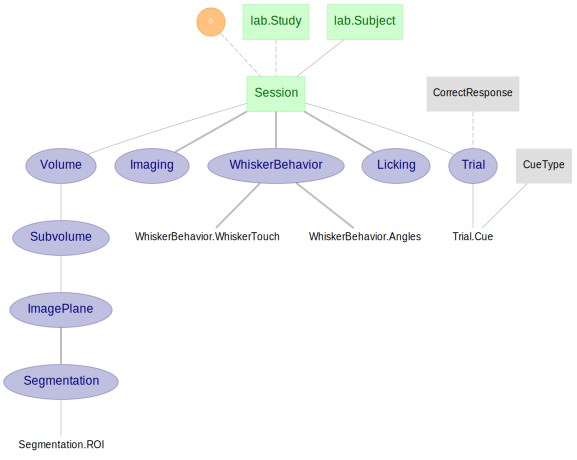

In [26]:
a

In [28]:
a.save('./erd.png')